# **P5 étude de marché**

Plan
1. Préparation des données
    1.1. Assemblage du Dataframe principal\
    1.2. Assemblade d'un DF qui donne des infos sur la consomation de Poulet\
    1.3. Merge du DF relatif au régime alimentaire dans le le DF prinicipal
    
2. Clustering\
    2.1 Par k-means\
    2.2 Par dendrogramme
    
3. Representation 2 ou 3-D\
    2.3.1 méthode de l'ACP et graphes\
    2.3.2 choix des PC, étude des "loading" en complément

3. Tests statistiques

In [1]:
#importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.datasets import load_digits
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#importation des données dans des dataframes
df1 = pd.read_csv("csv's/FAOSTAT_data_2-12-2022-2.csv")
df2 = pd.read_csv("csv's/FAOSTAT_data_2-11-2022-1.csv")
df2017 = pd.read_csv("csv's/FAOSTAT_data_2-14-2022.csv")
#données régime alimentaire
df_chick = pd.read_csv("csv's/FAOSTAT_data_2-12-2022.csv")
global_diet = pd.read_csv("csv's/FAOSTAT_data_2-14-2022-1b.csv")

## 1. **Préparation des données**

### 1.1. Assemblage du Dataframe principal

In [3]:
df1.columns == df2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [4]:
#les colonnes sont égales donc on peut concat
frames = [df2, df1]
pop = pd.concat(frames)
pop.head()

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,34413.603,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,55386.367,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,3,Albanie,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,2890.513,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,4,Algérie,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,39728.025,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,79,Allemagne,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,81787.411,X,Sources internationales sûres,NaN


In [5]:
#présence doublons?
pop.duplicated(keep=False)
if 'True' in (pop.duplicated(subset=['Zone','Valeur'],keep=False)):
    print('présence un doublon')
else:
    print('pas de doublons') 

pas de doublons


In [6]:
#fonction tester si clé est primaire ds une table
def testClePrim(df, column):
    if len(df) != len(df[column].drop_duplicates()):
        print("ce n'est pas une clé unique")
    else : print("c'est une clé unique")

testClePrim(pop, ['Zone', 'Année'])

c'est une clé unique


In [7]:
#on assemble un multi index
pop_p = pop.pivot_table(index = ['Zone'], values = 'Valeur', columns = 'Année')
#on ajoute une colonne du taux d'évolution de la population
pop_p['ev_2015-2017'] = ((pop_p[2017] - pop_p[2015])*100/pop_p[2015]).round(decimals=2)
pop_p.head(3)

Année,2015,2017,ev_2015-2017
Zone,,,
Afghanistan,34413.603,36296.113,5.47
Afrique du Sud,55386.367,57009.756,2.93
Albanie,2890.513,2884.169,-0.22


In [8]:
len(pop_p.index)

237

#### => le DF de l'évolution de la population comporte 237 pays

In [9]:
# test : unités
df2017[['Produit', 'Unité']].drop_duplicates()

,Produit,Unité
0,Disponibilité alimentaire par habitant utilisé...,Kcal/personne/jour
1,Disponibilités protéiques moyennes (g/personne...,g/personne/jour
2,Disponibilités protéines moyennes d’origine an...,g/personne/jour
3,"PIB par habitant, ($ PPA internationaux consta...",I$
4,Stabilité politique et absence de violence/ter...,indice


In [10]:
#recherche de potentiels duplicates du fichier df2017
df2017.duplicated(keep=False)
if 'True' in (pop.duplicated(subset=['Zone','Valeur'],keep=False)):
    print('présence un doublon')
else:
    print('pas de doublons') 

pas de doublons


In [11]:
#On nettoye le format des modalités de la var 'Année'
df2017['Année'] = df2017['Année'].str.replace('2016-2018','2017')
df2017['Année'] = pd.to_numeric(df2017['Année']) 
df2017['Année'].unique()

array([2017])

In [12]:
df2017['Valeur'].describe()

count       910.000000
mean       4856.300582
std       12892.750645
min          -2.940000
25%          14.075000
50%          82.350000
75%        3031.750000
max      126184.000000
Name: Valeur, dtype: float64

In [13]:
# on pivote le df pour avoir la var 'Produit' en colonnes
df2017_p = df2017.pivot_table(index = 'Zone', values = 'Valeur', columns = 'Produit')
df2017_p.head(3)
#On renomme les colonnes
df2017_p.rename(columns={
    "Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans)": 'dispo_alim',
    "PIB par habitant, ($ PPA internationaux constants de 2011)":'PIB_habitant'
}, inplace=True)
df2017_p.head()

Produit,dispo_alim,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB_habitant,Stabilité politique et absence de violence/terrorisme (indice)
Zone,,,,,
Afghanistan,2266.0,10.7,55.7,2058.4,-2.80
Afrique du Sud,2902.0,36.0,83.7,12701.3,-0.28
Albanie,3377.0,62.7,116.7,12771.0,0.38
Algérie,3402.0,25.6,92.3,11737.4,-0.92
Allemagne,3551.0,63.0,104.3,52952.9,0.59


In [14]:
#il y a 36 pays perdus dans le df du régime alimentaire
len(pop_p.index) - len(df2017_p.index)

36

In [15]:
#quels pays de pop_p ne sont PAS dans df2017_p?
np.setdiff1d(pop_p.index,df2017_p.index)

array(['Anguilla', 'Antilles néerlandaises (ex)', 'Aruba',
       'Bonaire, Saint-Eustache et Saba', 'Curaçao', 'Gibraltar',
       'Guadeloupe', 'Guam', 'Guyane française', 'Liechtenstein',
       'Martinique', 'Mayotte', 'Monaco', 'Montserrat', 'Nioué',
       'Réunion', 'Sahara occidental', 'Saint-Barthélemy', 'Saint-Marin',
       'Saint-Martin (partie française)', 'Saint-Pierre-et-Miquelon',
       'Saint-Siège', 'Sainte-Hélène, Ascension et Tristan da Cunha',
       'Sint Maarten (partie néerlandaise)', 'Tokélaou', 'Île de Man',
       'Îles Anglo-Normandes', 'Îles Caïmanes', 'Îles Cook',
       'Îles Falkland (Malvinas)', 'Îles Féroé', 'Îles Mariannes du Nord',
       'Îles Turques-et-Caïques', 'Îles Vierges américaines',
       'Îles Vierges britanniques', 'Îles Wallis-et-Futuna'], dtype=object)

In [16]:
#dans le sens inverse : quels pays de df2017_p ne sont PAS dans pop_p?
np.setdiff1d(df2017_p.index,pop_p.index)

array([], dtype=object)

In [17]:
#On calcule le taux de protéines
df2017_p['rate_prot'] = \
(df2017_p['Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)']/ \
df2017_p['Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)']).round(decimals=2)

In [18]:
df2017_p.head()#.index.unique()

Produit,dispo_alim,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB_habitant,Stabilité politique et absence de violence/terrorisme (indice),rate_prot
Zone,,,,,,
Afghanistan,2266.0,10.7,55.7,2058.4,-2.80,0.19
Afrique du Sud,2902.0,36.0,83.7,12701.3,-0.28,0.43
Albanie,3377.0,62.7,116.7,12771.0,0.38,0.54
Algérie,3402.0,25.6,92.3,11737.4,-0.92,0.28
Allemagne,3551.0,63.0,104.3,52952.9,0.59,0.60


In [19]:
df2017_p.isnull().sum()

Produit
dispo_alim                                                                                   21
Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)    28
Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)                     28
PIB_habitant                                                                                 14
Stabilité politique et absence de violence/terrorisme (indice)                                4
rate_prot                                                                                    28
dtype: int64

In [20]:
df2017_p = df2017_p.join(pop_p[['ev_2015-2017']])
df2017_p.head()

,dispo_alim,Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),PIB_habitant,Stabilité politique et absence de violence/terrorisme (indice),rate_prot,ev_2015-2017
Zone,,,,,,,
Afghanistan,2266.0,10.7,55.7,2058.4,-2.80,0.19,5.47
Afrique du Sud,2902.0,36.0,83.7,12701.3,-0.28,0.43,2.93
Albanie,3377.0,62.7,116.7,12771.0,0.38,0.54,-0.22
Algérie,3402.0,25.6,92.3,11737.4,-0.92,0.28,4.18
Allemagne,3551.0,63.0,104.3,52952.9,0.59,0.60,1.06


### 1.2. Assemblade d'un DF qui donne des infos sur la consomation de Poulet

In [21]:
df_chick.head(3)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28,Im,Données de la FAO basées sur une méthodologie ...
1,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29,Im,Données de la FAO basées sur une méthodologie ...
2,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5301,Disponibilité intérieure,2734,Viande de Volailles,2017,2017,Milliers de tonnes,64,S,Données standardisées


In [22]:
#fonction tester si clé est primaire ds une table
def testClePrim(df, column):
    if len(df) != len(df[column].drop_duplicates()):
        print("ce n'est pas une clé unique")
    else : print("c'est une clé unique")

testClePrim(df_chick, ['Zone', 'Élément'])

c'est une clé unique


In [23]:
#recherche de potentiels duplicates du fichier pop_p
df_chick.duplicated(keep=False)
if 'True' in (df_chick.duplicated(subset=['Zone','Valeur'],keep=False)):
    print('présence un doublon')
else:
    print('pas de doublons') 

pas de doublons


In [24]:
# test : unités
df_chick[['Élément', 'Unité']].drop_duplicates()

,Élément,Unité
0,Production,Milliers de tonnes
1,Importations - Quantité,Milliers de tonnes
2,Disponibilité intérieure,Milliers de tonnes
3,Disponibilité alimentaire (Kcal/personne/jour),Kcal/personne/jour


In [25]:
# multi index
df_chick['Valeur'] = pd.to_numeric(df_chick['Valeur']) 
#df2017['Valeur'] = df2017['Valeur']*1e3
#df2017['Valeur'].describe()
df_chick_p = df_chick.pivot_table(index = ['Zone'], values = 'Valeur', columns = 'Élément')
df_chick_p.head()

Élément,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure,Importations - Quantité,Production
Zone,,,,
Afghanistan,6.0,64.0,29.0,28.0
Afrique du Sud,149.0,2110.0,514.0,1665.0
Albanie,59.0,33.0,20.0,13.0
Algérie,24.0,286.0,2.0,284.0
Allemagne,67.0,1557.0,842.0,1514.0


#### on amène une colonne depuis un autre DF pour faire un df final sur le regime alimentaire

In [26]:
global_diet.head(3)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires (2010-),2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2511,Blé et produits,2017,2017,Kcal/personne/jour,1404,Fc,Donnée calculée
1,FBS,Bilans Alimentaires (2010-),2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2807,Riz et produits,2017,2017,Kcal/personne/jour,181,Fc,Donnée calculée
2,FBS,Bilans Alimentaires (2010-),2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2513,Orge et produits,2017,2017,Kcal/personne/jour,14,Fc,Donnée calculée


In [27]:
#fonction tester si clé est primaire ds une table
def testClePrim(df, column):
    if len(df) != len(df[column].drop_duplicates()):
        print("ce n'est pas une clé unique")
    else : print("c'est une clé unique")

testClePrim(global_diet, ['Zone', 'Produit'])

c'est une clé unique


In [28]:
glo_diet_p = global_diet.pivot_table(index = 'Zone', values = 'Valeur', columns = 'Élément', aggfunc=sum)
glo_diet_p.head(3)

Élément,Disponibilité alimentaire (Kcal/personne/jour)
Zone,
Afghanistan,2303
Afrique du Sud,2896
Albanie,3324


In [29]:
#On ajoute la colonne disponibilité alimentaire globale nationale au df chicken
diet_df = pd.merge(glo_diet_p, 
                              df_chick_p, 
                              on = 'Zone', 
                              how = 'left'
                             )

In [30]:
diet_df.head()

Élément,Disponibilité alimentaire (Kcal/personne/jour)_x,Disponibilité alimentaire (Kcal/personne/jour)_y,Disponibilité intérieure,Importations - Quantité,Production
Zone,,,,,
Afghanistan,2303,6.0,64.0,29.0,28.0
Afrique du Sud,2896,149.0,2110.0,514.0,1665.0
Albanie,3324,59.0,33.0,20.0,13.0
Algérie,3380,24.0,286.0,2.0,284.0
Allemagne,3545,67.0,1557.0,842.0,1514.0


In [31]:
#on calcule le taux de Poulet disponible comme reflet du régime alimentaire
diet_df['chick_rate'] = (diet_df['Disponibilité alimentaire (Kcal/personne/jour)_y']\
                         /diet_df['Disponibilité alimentaire (Kcal/personne/jour)_x'])\
#.round(decimals=2)

In [32]:
#on calcule aussi taux d'importation de Poulet comme possible reflet du régime alimentaire
diet_df['chick_import_rate'] = (diet_df['Importations - Quantité']\
                         /diet_df['Disponibilité intérieure'])\
.round(decimals=2)
diet_df.head()

Élément,Disponibilité alimentaire (Kcal/personne/jour)_x,Disponibilité alimentaire (Kcal/personne/jour)_y,Disponibilité intérieure,Importations - Quantité,Production,chick_rate,chick_import_rate
Zone,,,,,,,
Afghanistan,2303,6.0,64.0,29.0,28.0,0.002605,0.45
Afrique du Sud,2896,149.0,2110.0,514.0,1665.0,0.051450,0.24
Albanie,3324,59.0,33.0,20.0,13.0,0.017750,0.61
Algérie,3380,24.0,286.0,2.0,284.0,0.007101,0.01
Allemagne,3545,67.0,1557.0,842.0,1514.0,0.018900,0.54


In [33]:
diet_df.shape

(180, 7)

### 1.3. Merge du DF relatif au régime alimentaire dans le le DF prinicipal

In [34]:
#comparaison des df
df2017_p.shape, diet_df.shape

((201, 7), (180, 7))

In [35]:
#il y a 21 pays perdus dans le df du régime alimentaire
len(df2017_p.index) - len(diet_df.index)

21

In [36]:
#quels pays de df2017_p ne sont PAS dans diet_df?
np.setdiff1d(df2017_p.index,diet_df.index)

array(['Andorre', 'Bahreïn', 'Bermudes', 'Bhoutan', 'Brunéi Darussalam',
       'Groenland', 'Guinée équatoriale', 'Micronésie (États fédérés de)',
       'Nauru', 'Palaos', 'Palestine', 'Porto Rico', 'Qatar',
       'Samoa américaines', 'Singapour', 'Somalie', 'Soudan du Sud',
       'Tonga', 'Tuvalu', 'Érythrée', 'Îles Marshall'], dtype=object)

In [37]:
#quels pays de diet_df ne sont PAS dans df2017?
np.setdiff1d(diet_df.index,df2017_p.index)

array([], dtype=object)

#### => On fait un join gauche de manière à ne pas perdre de pays du DF principal (df2017_p), pour les NAN qui seront engendrés, on les traitera

In [38]:
# On fait un join gauche pour ajouter la ver évolution de la population et garder les pays du df principal
glo_df2017 = df2017_p[["dispo_alim",\
                       'PIB_habitant',\
                       'Stabilité politique et absence de violence/terrorisme (indice)',\
                       'rate_prot',\
                      'ev_2015-2017']]\
            .join(diet_df[['chick_rate', 'chick_import_rate']])

In [39]:
glo_df2017.head()

,dispo_alim,PIB_habitant,Stabilité politique et absence de violence/terrorisme (indice),rate_prot,ev_2015-2017,chick_rate,chick_import_rate
Zone,,,,,,,
Afghanistan,2266.0,2058.4,-2.80,0.19,5.47,0.002605,0.45
Afrique du Sud,2902.0,12701.3,-0.28,0.43,2.93,0.051450,0.24
Albanie,3377.0,12771.0,0.38,0.54,-0.22,0.017750,0.61
Algérie,3402.0,11737.4,-0.92,0.28,4.18,0.007101,0.01
Allemagne,3551.0,52952.9,0.59,0.60,1.06,0.018900,0.54


In [40]:
glo_df2017.isnull().sum()

dispo_alim                                                        21
PIB_habitant                                                      14
Stabilité politique et absence de violence/terrorisme (indice)     4
rate_prot                                                         28
ev_2015-2017                                                       0
chick_rate                                                        21
chick_import_rate                                                 22
dtype: int64

In [41]:
# on remplace les NAN par la moyenne de la variable
for col in glo_df2017.columns :
    glo_df2017[col].fillna(glo_df2017[col].mean(), inplace=True)

In [42]:
#On teste le résultat
glo_df2017.isnull().sum()

dispo_alim                                                        0
PIB_habitant                                                      0
Stabilité politique et absence de violence/terrorisme (indice)    0
rate_prot                                                         0
ev_2015-2017                                                      0
chick_rate                                                        0
chick_import_rate                                                 0
dtype: int64

In [43]:
glo_df2017.shape

(201, 7)

## **2.1 Clustering**

## 2.2 Clustering par dendrogramme 
source méthode Ward : cours du Pr F. Husson https://www.youtube.com/watch?v=SE_4dLh5vXY, \
source du code https://www.python-graph-gallery.com/400-basic-dendrogram#google_vignette

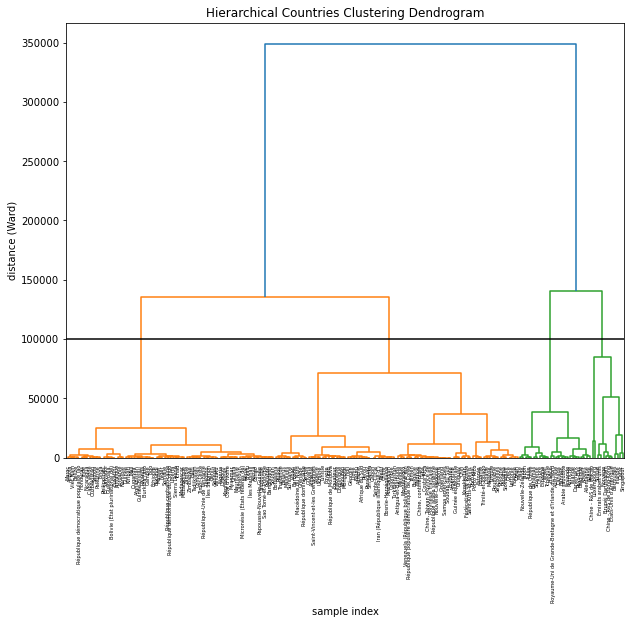

<Figure size 432x288 with 0 Axes>

In [44]:
# Calculate the distance between each sample
# You have to think about the metric you use (how to measure similarity) + about the method of clusterization you use (How to group)
Z = linkage(glo_df2017, 'ward')

# Plot title
plt.figure(figsize=(10,8))
plt.title('Hierarchical Countries Clustering Dendrogram')
# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')
# Make the dendrogram
dendrogram(Z, labels=glo_df2017.index, leaf_rotation=90)
# Cutting the dendrogram
plt.axhline(y=100000, c='k')
# Show the graph
plt.show()
plt.savefig("dendrogram.png")

#### Couper le dedrogramme
see https://stackoverflow.com/questions/46869640/alternative-to-scipy-cluster-hierarchy-cut-tree

In [45]:
#on coupe le dedondrogramme de manière à n'avoir que 4 groupes
clust = fcluster(Z, 4, criterion='maxclust')

In [46]:
#On créée un dictionnaire pour mapper les groupes et leur nom de pays
#l'axe des abcisses est sample index donc on peut les assembler sans agir sur l'ordre
dict_group = {"Zone":glo_df2017.index,
          "Groupe":clust}

In [47]:
clust_df = pd.DataFrame(dict_group)
#clust_df.to_csv("pays_groupes.csv")

#### méthode 'k-means' (hierarchisation 'flat')

In [48]:
# On fait une boucle pour évaluer le nombre optimal de groupes dans les données
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(glo_df2017)
    distortions.append(kmeanModel.inertia_)

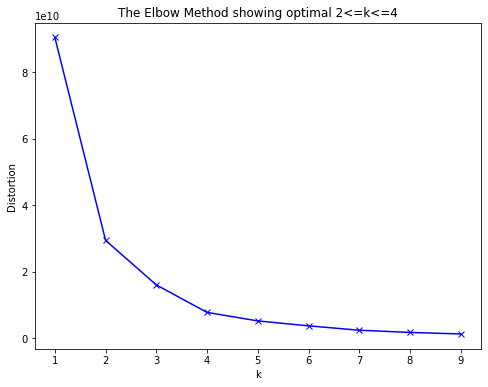

In [49]:
# On plot graphiquement une courbe 'Elbow'
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal 2<=k<=4')
#plt.savefig("elbow_for_best_k.png")
plt.show()

=> La Courbe Elbow suggère un nombre de groupes optimal entre 2 et 4. Si on compare ce résultat au dendrogramme, on peut décider en tant qu'humain que le 4 est un 

In [50]:
#on prepare les données et paramètre le modèle k-means
data = scale(glo_df2017)
model = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10)
#On entre les données du DF
k_means = model.fit(data)

In [51]:
# on sort le label du cluster dans une nouvelle variable
glo_df2017['cluster'] = k_means.labels_
glo_df2017['cluster'].value_counts()

1    76
0    69
2    31
3    25
Name: cluster, dtype: int64

In [52]:
glo_df2017.isnull().sum()

dispo_alim                                                        0
PIB_habitant                                                      0
Stabilité politique et absence de violence/terrorisme (indice)    0
rate_prot                                                         0
ev_2015-2017                                                      0
chick_rate                                                        0
chick_import_rate                                                 0
cluster                                                           0
dtype: int64

### Position des centroïdes

In [53]:
#position des centroïdes dans un espace à 6 dimensions
coord_center = glo_df2017.groupby('cluster').mean()\
.sort_values('PIB_habitant', ascending=False)
coord_center#.index[0]
#coord_center.to_csv('coord_cluster_kmeans.csv')

,dispo_alim,PIB_habitant,Stabilité politique et absence de violence/terrorisme (indice),rate_prot,ev_2015-2017,chick_rate,chick_import_rate
cluster,,,,,,,
2,3361.626882,60208.670968,0.879677,0.577162,1.827419,0.029917,0.688317
3,2866.560000,19426.533861,0.357858,0.542920,1.805200,0.064859,0.514400
0,3024.430918,18805.247237,0.140528,0.459262,0.683188,0.023914,0.329760
1,2501.682456,6911.201576,-0.767500,0.287764,4.816316,0.011329,0.472391


### Choix : le groupe dont le PIB est le plus élevé, puis filtre

In [54]:
#à partir de la position des centroïdes, on choisit le cluster ayant le PIB le plus élevé
#et on filtre sur les pays stables politiquement
#au sein du cluster filtré, on choisit le Top 5 de ceux qui consomment le plus de poulet
glo_df2017.loc[(glo_df2017['cluster'] == coord_center.index[0])\
               & (glo_df2017['Stabilité politique et absence de violence/terrorisme (indice)'] >= 0)]\
                .sort_values(by=['chick_rate']\
                 , ascending=False).head(5).index

Index(['Australie', 'États-Unis d'Amérique', 'Chine - RAS de Hong-Kong',
       'Canada', 'Chine - RAS de Macao'],
      dtype='object', name='Zone')

=> On trouve  les US, Hong-Kong, le Canada, Macao et Australie

## **3. Projection des donées par ACP**

### 3.1. Comment sont distribuées les variables qui serviront pour l'ACP

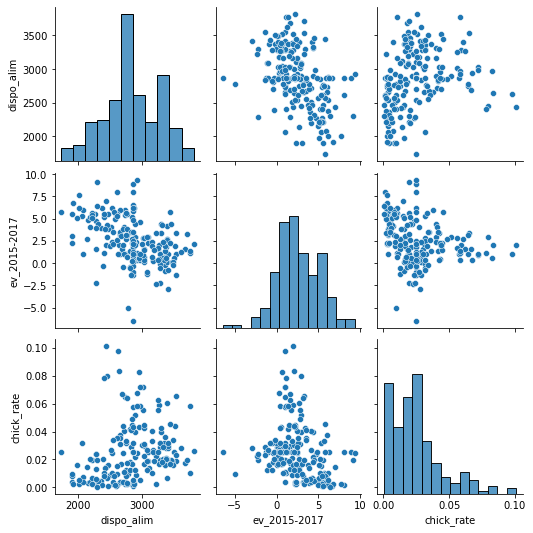

In [55]:
#on procède par sondage : on étudie 3 var qui semblent particulièrement d'intérêt pour la problématique
sns.pairplot(glo_df2017[["dispo_alim",\
'ev_2015-2017',\
'chick_rate']])#,
            #kind="reg", plot_kws={'line_kws':{'color':'black'}})
#plt.xticks(rotation=80)

Text(0.5, 1.0, 'distribution disponibilité alimentaire')

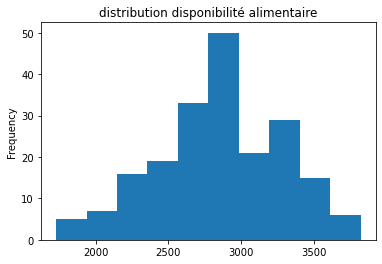

In [56]:
glo_df2017["dispo_alim"].plot(kind='hist')
plt.title('distribution disponibilité alimentaire')

=> A ce stade, on considère que cette distribution suit une loi Gaussienne avec une marge d'erreur (on développera la problématique de tests statistiques dans un paragraphe ultérieur)

Text(0.5, 1.0, 'ev_2015-2017')

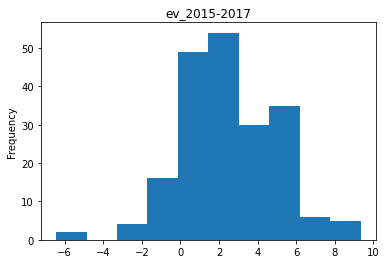

In [57]:
glo_df2017["ev_2015-2017"].plot(kind='hist')
plt.title('ev_2015-2017')

=> On remarque que la distribution de la variable semble suivre une loi Gaussienne, La méthode ACP suppose des variables distribuées selon une loi Gaussienne

Text(0.5, 1.0, 'distribution modalités var : taux de disponibilité viande volaille')

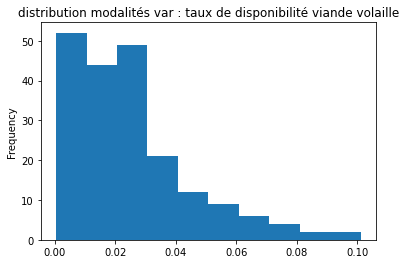

In [58]:
glo_df2017["chick_rate"].plot(kind='hist')
plt.title('distribution modalités var : taux de disponibilité viande volaille')

=> Ici encore on a pas une Loi Gaussienne mais on considère qu'elle s'en approche suffisemment\
pour y appliquer une ACP

On relève au moins une variable qui ne suit pas du tout une Loi Gaussienne pour illustrer mais remarquons qu'elle contribue relativement peu au composantes principales qui seront utilisées pour illustrer les groupes : le PIB

Text(0.5, 1.0, 'distribution variable PIB/hab')

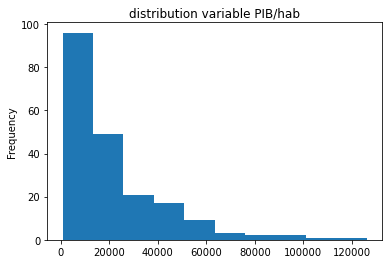

In [59]:
glo_df2017["PIB_habitant"].plot(kind='hist')
plt.title('distribution variable PIB/hab')

## Méthode de l'ACP

On suit la méthode de 'Epimed' https://github.com/epimed/eoc-ai-session-2/blob/main/notebook/demo_pca_tsne_umap.ipynb

In [60]:
# Données des caractéristiques de pays, on split le jeur de données
glo = glo_df2017.drop('cluster', axis=1)
X = glo.select_dtypes('number') 
#on mets la var cluster dans un objet séparé, elle ne fait pas partie des données à analyser
#mais elle nous servira pour comparer la classification k-means vs. structure graphique PCA
y = glo_df2017['cluster']

<AxesSubplot:ylabel='Distribution'>

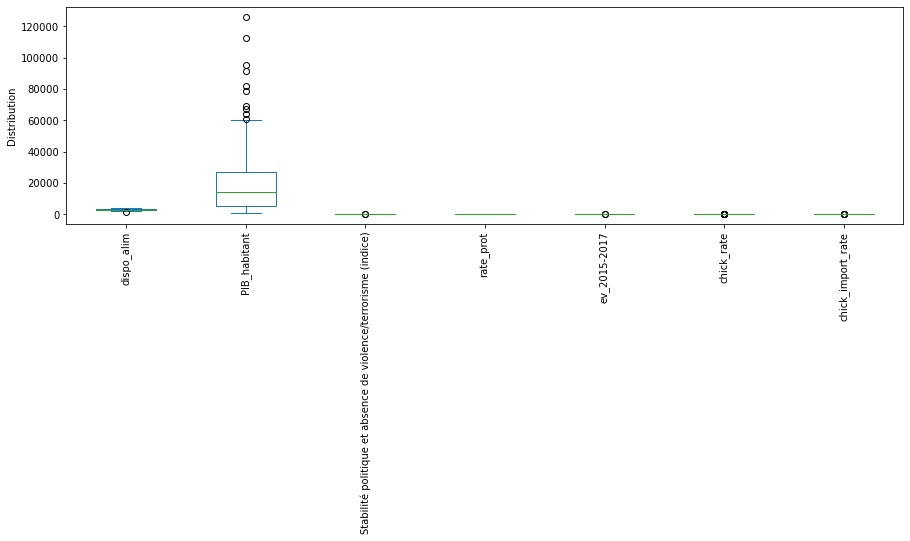

In [61]:
#on observe la variance des variables
X.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Distribution')

In [62]:
scaler = StandardScaler() # instanciation de l'objet scaler
X_scaled = scaler.fit_transform(X) # normalisation centrée-réduite
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # conversion du résultat en objet dataframe de pandas

In [63]:
#for i in X_scaled.columns:
    #cov_m = np.cov(X_scaled.columns[i])

<AxesSubplot:ylabel='Distribution'>

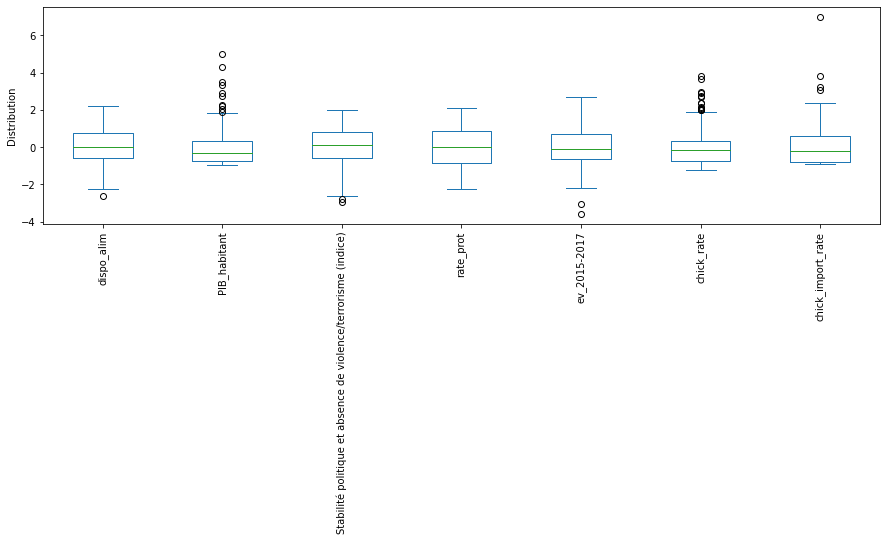

In [64]:
X_scaled.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Distribution')

In [65]:
#On plot les coordonnées en 6 dimensions dans le plan engendré par les eigenvecteurs
pca = PCA() # instanciation de l'objet pca
X_p = pca.fit_transform(X_scaled)
pca_columns = ['PC' + str(c) for c in range(1, X_p.shape[1]+1, 1)]

X_pca = pd.DataFrame(X_p, index=X.index, columns=pca_columns) # création du dataframe
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Zone,,,,,,,
Afghanistan,-3.633134,0.078289,-0.234840,-0.295089,1.386373,0.533151,-0.087139
Afrique du Sud,0.150100,-0.303882,1.171658,-0.717593,0.118021,-0.273600,-0.304704
Albanie,1.210651,-0.449190,-0.244817,1.097814,0.354252,-0.834240,0.343608
Algérie,-1.141557,-1.264373,-1.049718,-0.405404,0.378943,-1.034037,-0.358094
Allemagne,2.269563,-0.393236,-1.328893,-0.054386,0.282237,-0.054586,0.254512


In [66]:
#print(pca.explained_variance_ratio_)
explained_variance = pd.Series(dict(zip(X_pca.columns, 100.0*pca.explained_variance_ratio_)))
print(explained_variance)

PC1    46.585733
PC2    16.119275
PC3    12.337709
PC4     9.442192
PC5     7.382710
PC6     4.851960
PC7     3.280421
dtype: float64


#### Quelle est la relation entre les PC et les var initiales? 
loadings "wi" : "would represent each features influence on the associated PC"\
see https://stackoverflow.com/questions/67585809/how-to-map-the-results-of-principal-component-analysis-back-to-the-actual-featur

In [67]:
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=PCnames,index=X.columns)

Loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
dispo_alim,0.410735,0.413203,0.408904,0.493752,-0.347486,0.333793,0.131913
PIB_habitant,-0.336899,0.026009,0.203961,0.067440,0.358246,0.073653,0.840184
Stabilité politique et absence de violence/terrorisme (indice),-0.361843,-0.492702,-0.045072,0.130807,-0.206767,0.743702,-0.106430
rate_prot,-0.099815,-0.348139,0.172827,-0.093934,-0.753330,-0.419534,0.294328
ev_2015-2017,0.265248,0.025364,-0.851570,0.209525,-0.163235,0.063462,0.359520
chick_rate,-0.670456,0.645414,-0.183838,0.000751,-0.293309,-0.008391,-0.118454
chick_import_rate,-0.238818,-0.217779,-0.018117,0.825727,0.167267,-0.387245,-0.188276


Text(0.5, 1.0, 'PC2 loadings')

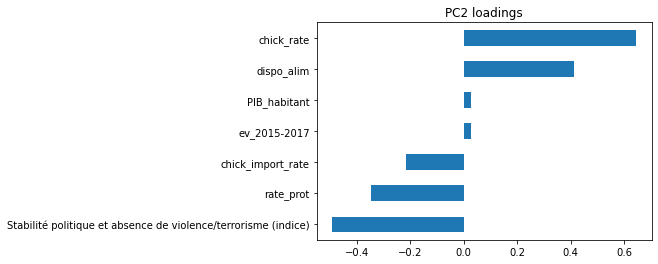

In [68]:
Loadings["PC2"].sort_values().plot.barh()
plt.title('PC2 loadings')
#plt.savefig("loadings_PC2.png")

=> En testant les 7 PC, on observe que la PC2 est celle dont la valeur de la composante selon la variable 'chick_rate' est la plus forte (une variable particulièrment intéressante pour notre analyse donc). \
=> Mais dès lors que l'on plot les donnés sur 2 PC ou plus, cet aspect, seul, n'est plus suffisant dans le choix des PC si l'on veut que la variance des individus projetés soit suffisament élevée pour que la projection soit lisible

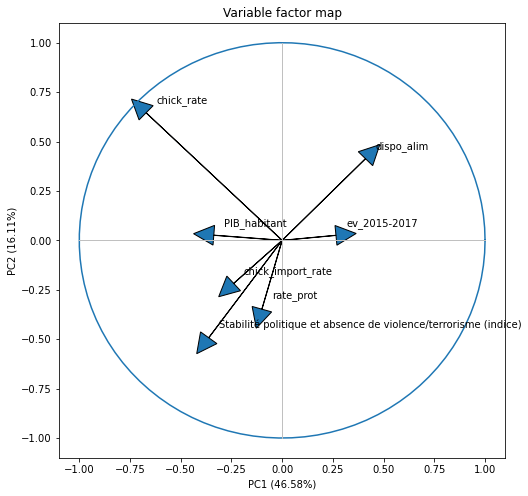

In [69]:
# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[0]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[i, 0],  #0 for PC1
             pca.components_[i, 1],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[i, 0] + 0.05,
             pca.components_[i, 1] + 0.05,
             X.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

plt.xlabel("PC1 (%s%%)" % str(explained_variance[0])[:5].lstrip("0."))
plt.ylabel("PC2 (%s%%)" % str(explained_variance[1])[:5].lstrip("0."))
ax.set_title('Variable factor map')
#plt.savefig("correlation_circle.png")
plt.show()

=> Le cercle de corrélation montre que la var taux de poulet dans la disponibilité alimentaire est bien représentée lorsqu'elle est plottée dans le 1er plan factoriel. C'est bien pour notre analyse car c'est la seule variable qui reflète la consomation de poulet. On remarque aussi que cette variable est faiblement corrélée au PIB

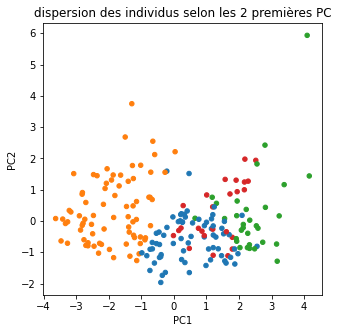

In [70]:
#On projette sur le plan généré par les 2 composantes principales qui comptent pour ~ 68% de la variabilité des données
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red'}
X_pca.plot(x='PC1', y='PC2', kind='scatter', c=y.map(colors), figsize=(5, 5))
plt.title('dispersion des individus selon les 2 premières PC')

#plt.savefig("PCA_plane.png")
plt.show()

=> On observe en comparant avec la méthode K-means que l'ACP a assez bien préservé la structure du dataset : la méthode k-means montrait 2=<k<=4, l'ACP aussi

### On teste la cohérence de l'ACP avec le dendrogramme

Text(0.5, 1.0, 'dispersion des individus selon les 2 premières PC (comparaison avec dendrogramme)')

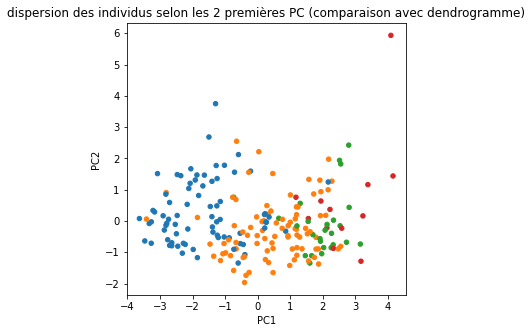

In [71]:
#On projette sur le plan généré par les 2 composantes principales qui comptent pour ~ 68% de la variabilité des données
colors2 = {1:'tab:blue', 2:'tab:orange', 3:'tab:green', 4:'tab:red'}
X_pca.plot(x='PC1', y='PC2', kind='scatter', c=clust_df.Groupe.map(colors2), figsize=(5, 5))
plt.title('dispersion des individus selon les 2 premières PC (comparaison avec dendrogramme)')
#plt.savefig("PCA_plane_dend.png")

#### => On observe que les groupes du dendrogramme correspondent mal avec la structure des données que l'ACP dégage (pour k=4) ... La pertinence du dedrogramme doit être limitée

Text(0.5, 0.92, 'sample plotted on first 3 PCs')

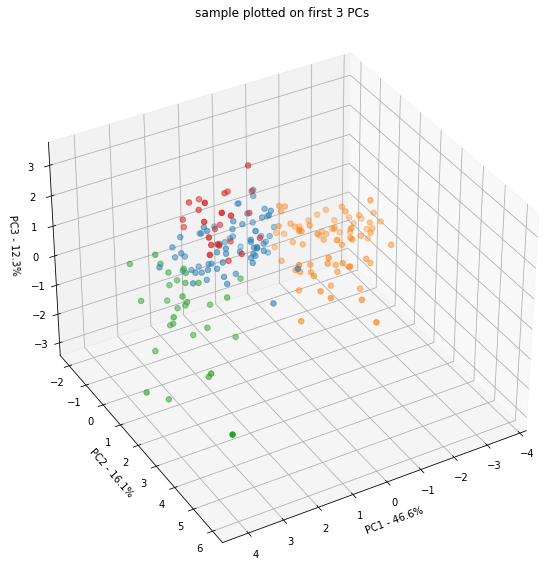

In [72]:
# On projette sur les 3 composantes principales par ordre d'importance pour les 2 premières\
#pour la 3ème, on retient la PC3 pas la PC4 car les PC sont pertinentes en tant que combinaison pas individuellement
#elles comptent pour ~75% de la variabilité des données

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], marker='o', s=30, c=y.map(colors))
ax.set_xlabel('PC1 - ' + '{:.1f}%'.format(explained_variance['PC1']))
ax.set_ylabel('PC2 - ' + '{:.1f}%'.format(explained_variance['PC2']))
ax.set_zlabel('PC3 - ' + '{:.1f}%'.format(explained_variance['PC3']))
ax.view_init(elev=35, azim=60)
plt.title('sample plotted on first 3 PCs')
#plt.savefig("PCA_3D.png")

=> On plot les données dans la base formée par les 2 composantes principales qui maximisent la Variance et la PC3 qui ne compte que ~12% de la Variance. On s'attends à ce que l'information quant au dataset soit faible si on plot par PC3 mais cela apporte tout de même une information sur la structure des données car on peut représenter le dataset en 3-D

### **Tests statistiques**

In [73]:
import statsmodels.api as sm
from scipy.stats import shapiro, ttest_ind
from statistics import variance

In [74]:
#on observe la variable choisie
glo_df2017["Stabilité politique et absence de violence/terrorisme (indice)"].describe()

count    201.000000
mean      -0.061777
std        0.984924
min       -2.940000
25%       -0.650000
50%        0.030000
75%        0.750000
max        1.920000
Name: Stabilité politique et absence de violence/terrorisme (indice), dtype: float64

(array([ 3., 10.,  6., 11., 29., 40., 35., 34., 30.,  3.]),
 array([-2.94 , -2.454, -1.968, -1.482, -0.996, -0.51 , -0.024,  0.462,
         0.948,  1.434,  1.92 ]),
 <BarContainer object of 10 artists>)

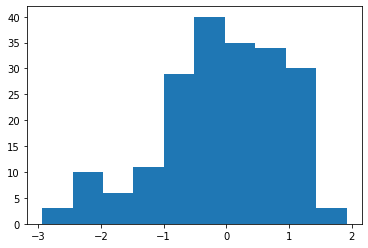

In [75]:
#On teste quelques plot et on décide d'analyser la var 'stabilité politique...'
plt.hist(glo_df2017["Stabilité politique et absence de violence/terrorisme (indice)"])

/home/zuko/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


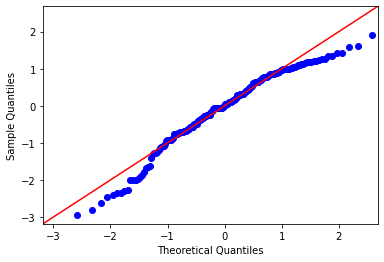

In [76]:
#La variable stabilité politique est-elle distribuée normalement?
#On fait un Q-Q plot pour voir si cette variable est distribuée normalement
fig = sm.qqplot(glo_df2017["Stabilité politique et absence de violence/terrorisme (indice)"], line='45')
plt.show()

In [77]:
#On a une variable 
#H0 la variable suit une Loi normale
#H1 la variable ne suit pas une Loi normale
shapiro(glo_df2017["Stabilité politique et absence de violence/terrorisme (indice)"])

ShapiroResult(statistic=0.9603392481803894, pvalue=2.052609488600865e-05)

=> p-value << 0.05 donc l'hypothèse que la variable est distribuée normalement est rejetée\
L'histogramme indique tout de même un silhouette qui aurait été comparable à la Courbe de Gauss si elle n'était pas 'skewed'

### comparaison de 2 sous échantillons

In [78]:
#on définit 2 sous échantillons
echa_1 = glo_df2017.loc[glo_df2017['cluster'] == coord_center.index[2]].drop('cluster', axis=1)
echa_2 = glo_df2017.loc[glo_df2017['cluster'] == coord_center.index[3]].drop('cluster', axis=1)

In [79]:
#conditions du test de Student : 
variance(echa_1["Stabilité politique et absence de violence/terrorisme (indice)"])\
, variance(echa_2["Stabilité politique et absence de violence/terrorisme (indice)"])

(0.6925589467815108, 0.7971763333333333)

In [80]:
#les individus sont différents dans chaque groupe donc on applique un 'Independent Group t-test'
#H0 : les échantillons sont semblables en termes de leur moyennes
#H1 : les échantillons viennent de populations différentes en termes de moyennes pour les var choisies
ttest_ind(echa_1["Stabilité politique et absence de violence/terrorisme (indice)"], \
          echa_2["Stabilité politique et absence de violence/terrorisme (indice)"])

Ttest_indResult(statistic=6.31628825544944, pvalue=3.18430104055519e-09)

### => p-values << 0.05 donc les échantillons viennent de populations différentes on avait indiqué que la variable stabilité politique était celle dont la distribution était la plus proche d'une loi gaussienne

### déterminer le pays le plus représentatif de son groupe

In [81]:
#methode arg min
#on avait défini k_means plus haut, data est le df principal que l'on avait scale pour appliquer K-means
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(k_means.cluster_centers_, data)
closest, _

(array([116,  67,  50, 180]),
 array([0.84516814, 0.89003505, 0.90839431, 0.83735699]))

In [82]:
var = pd.DataFrame(columns=glo_df2017.columns)
for i in closest:
    var = var.append(pd.DataFrame(glo_df2017.loc[[glo_df2017.index[i]]]))

In [83]:
#pays représentatif (le plus proche de sa centroïde) par cluster
var

,dispo_alim,PIB_habitant,Stabilité politique et absence de violence/terrorisme (indice),rate_prot,ev_2015-2017,chick_rate,chick_import_rate,cluster
Nauru,2859.144444,12975.4,0.52,0.423006,1.83,0.025174,0.461955,0
Guatemala,2511.000000,8322.2,-0.65,0.310000,4.08,0.026835,0.360000,1
Danemark,3388.000000,55356.7,0.87,0.670000,0.77,0.028555,0.910000,2
Trinité-et-Tobago,2978.000000,26342.6,0.28,0.510000,1.00,0.072123,0.270000,3
